<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/cluste_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [119]:
!pip install BIO
!sudo apt install clustalw
# !pip install toytree toyplot
!git clone -b RAPID https://github.com/alibekk93/IDP_analysis
!cd /content/IDP_analysis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clustalw is already the newest version (2.1+lgpl-7).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Cloning into 'IDP_analysis'...
remote: Enumerating objects: 2586, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (744/744), done.
remote: Total 2586 (delta 336), reused 831 (delta 254), pack-reused 1584
Receiving objects: 100% (2586/2586), 2.12 GiB | 21.56 MiB/s, done.
Resolving deltas: 100% (1128/1128), done.
Updating files: 100% (734/734), done.


In [120]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

In [121]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [122]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [123]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

Psychrophiles would be dropped from this version

In [124]:
tempura = tempura[tempura['Topt_ave'] > 20]
tempura['group'] = ['thermophilic' if t >= 40 else 'mesophilic' for t in tempura['Topt_ave']]

Loading all_proteins

In [125]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
all_proteins = pd.read_csv('/content/all_proteins_types.csv', index_col=0)

Merging all_proteins with temura

In [126]:
all_proteins = all_proteins.merge(tempura, left_on='Species', right_on='genus_and_species')

setting colors

In [127]:
green = '#1BE434'
red = '#E4341B'

## Clustering all proteins using CD-HIT

In [ ]:
# # saving all proteins to a single fasta file
# with open('/content/all_proteins.fasta', 'w') as fasta_file:
#   for _, row in all_proteins_rapid.iterrows():
#     id = row['ID']
#     seq = row['Sequence']
#     fasta_file.write(f'>{id}\n{seq}\n')

CH-HIT ran on local system using command:
```
cd-hit -i all_proteins.fasta -o all_proteins_70 -c 0.7
```

Importing CD-HIT results

In [23]:
clustered_proteins_file = '/content/IDP_analysis/datafiles/CD-HIT/all_proteins_70.clstr'

all_proteins['cluster'] = 0
clusters = {}

# Read the clustered proteins file and store clusters
with open(clustered_proteins_file ,'r') as f:
  for line in f:
    if line.startswith('>Cluster'):
      cluster_id = int(line.strip().split()[1])
      clusters[cluster_id] = []
    else:
      protein_id = line.strip().split('>')[1].split('...')[0]
      clusters[cluster_id].append(protein_id)

In [24]:
protein_cluster_mapping = {cid: proteins for cid, proteins in clusters.items()}
# Reverse cluster dictionary to have ID:cluster
protein_cluster_mapping = {protein_id: cluster for cluster, proteins in protein_cluster_mapping.items() for protein_id in proteins}
# Map clusters to df
all_proteins['cluster'] = all_proteins['ID'].map(protein_cluster_mapping)

We will filter to find clusters that:

1. Have at least 10 different species
2. Have at least 1 disordered protein

We will call these clusters `interesting_clusters` because they are, well, interesting

In [25]:
cluster_groups = all_proteins.groupby('cluster', as_index=False).agg({'candidate_idp':'max', 'Species':'nunique'})

In [26]:
min_cluster_size = 10

interesting_cluster_ids = cluster_groups[(cluster_groups['candidate_idp']) & (cluster_groups['Species']>=min_cluster_size)]['cluster']

In [27]:
len(interesting_clusters)

726

In [29]:
interesting_clusters = all_proteins[all_proteins['cluster'].isin(interesting_cluster_ids)]
interesting_clusters = interesting_clusters[interesting_clusters['Length'] >= 20]
# interesting_clusters.to_csv('interesting_clusters.csv')

Saving all proteins from `interesting_clusters` as `fasta` to predict their disorder using **fIDPnn**


In [ ]:
# !mkdir /content/IDP_analysis/clustered_fastas/

mkdir: cannot create directory ‘/content/IDP_analysis/clustered_fastas/’: File exists


In [ ]:
# # define the maximum sequences per file
# max_sequences_per_file = 430

# # split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
# for i, chunk in enumerate(range(0, len(disordered_clusters), max_sequences_per_file)):
#   chunk_df = disordered_clusters.iloc[chunk:chunk + max_sequences_per_file]
#   # create a FASTA file for the chunk
#   fasta_file_path = f'/content/IDP_analysis/clustered_fastas/clustered_proteins_{i+1}.fasta'
#   with open(fasta_file_path, 'w') as fasta_file:
#     for _, row in chunk_df.iterrows():
#       id = row['ID']
#       seq = row['Sequence']
#       fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
# !zip -r /content/clustered_fastas.zip /content/IDP_analysis/clustered_fastas -i '*.fasta'
# from google.colab import files
# files.download('/content/clustered_fastas.zip')

  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_4.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_3.fasta (deflated 62%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_2.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_1.fasta (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cluster analysis

In [56]:
# interesting_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/interesting_clusters.csv', index_col=0)
# interesting_clusters = pd.read_csv('/content/interesting_clusters.csv', index_col=0)

In [57]:
fIDPnn_dfs = {}
df_lines = []

with open('/content/fIDPnn_ALL.csv', 'rb') as f:
  for i, line in enumerate(tqdm(f.readlines())):
    line_decoded = line.decode('utf-8')
    if line_decoded[0] == '>':
      if df_lines != []:
        current_df = pd.DataFrame(np.array(df_lines)[1:, :], columns=np.array(df_lines)[0])
        fIDPnn_dfs[protein_id] = current_df.apply(pd.to_numeric, errors='ignore')
      protein_id = line_decoded[1:-1]
      df_lines = []
    else:
      df_lines.append(line_decoded.strip().split(','))

100%|██████████| 4443230/4443230 [01:23<00:00, 52937.23it/s]


In [58]:
len(fIDPnn_dfs)

13031

In [59]:
interesting_clusters.groupby('cluster').size()

cluster
508.0       18
2834.0      11
2865.0      11
3668.0      11
3937.0      11
            ..
946899.0    38
946903.0    16
946977.0    13
947413.0    35
948341.0    17
Length: 616, dtype: int64

In [60]:
fIDPnn_disorder_list = []
failures = []

for id in tqdm(interesting_clusters['ID']):
  try:
    fIDPnn_disorder_list.append(fIDPnn_dfs[id]['Predicted Score for Disorder'])
  except:
    fIDPnn_disorder_list.append(None)
    failures.append(id)

interesting_clusters['fIDPnn_disorder'] = fIDPnn_disorder_list

100%|██████████| 11476/11476 [00:00<00:00, 11737.41it/s]


In [61]:
failures

[]

In [66]:
clusters_df = interesting_clusters.copy()

In [67]:
clusters_df['fIDPnn_FOD'] = clusters_df['fIDPnn_disorder'].apply(np.mean)
clusters_df['fIDPnn_binary'] = clusters_df['fIDPnn_disorder'].apply(lambda disorder: [r >= 0.5 for r in disorder])
clusters_df['fIDPnn_longest_IDR'] = clusters_df['fIDPnn_binary'].apply(find_longest_binary_IDR)
clusters_df['fIDPnn_with_IDR'] = clusters_df['fIDPnn_longest_IDR'] > 30

In [68]:
aligned_clusters = {}

for cluster, cluster_df in tqdm(large_clusters.items()):
  try:
    cluster_df['disorder_aligned'] = align_disorder(disorder_values=cluster_df['fIDPnn_disorder'],
                                                    seqs=cluster_df['Sequence'], ids=cluster_df['ID'])[1]

    cluster_df['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in cluster_df['Species']]

    cluster_df['color'] = cluster_df['group'].map({'psychrophilic':'blue',
                                                    'mesophilic':'green',
                                                    'thermophilic':'red'})
    cluster_df['species_tag'] = cluster_df['Species']

    aligned_clusters[cluster] = cluster_df
  except:
    aligned_clusters[cluster] = None

100%|██████████| 529/529 [10:43<00:00,  1.22s/it]


In [70]:
# with open('/content/IDP_analysis/datafiles/clusters/aligned_clusters.pkl', 'wb') as f:
#   pickle.dump(aligned_clusters, f)

In [ ]:
# with open('/content/IDP_analysis/datafiles/clusters/aligned_clusters.pkl', 'rb') as f:
#   aligned_clusters = pickle.load(f)
with open('/content/aligned_clusters.pkl', 'rb') as f:
  aligned_clusters = pickle.load(f)

Finding clusters that are either unique for a group or have combinations

In [71]:
m_only_clusters = {}
t_only_clusters = {}
combination_clusters = {}

for cluster, cluster_df in tqdm(aligned_clusters.items()):
  try:
    groups = cluster_df['group'].unique().tolist()
    if groups == ['mesophilic']:
      m_only_clusters[cluster] = cluster_df
    elif groups == ['thermophilic']:
      t_only_clusters[cluster] = cluster_df
    else:
      combination_clusters[cluster] = cluster_df
  except:
    continue

100%|██████████| 529/529 [00:00<00:00, 19783.57it/s]


In [72]:
print(len(m_only_clusters))
print(len(t_only_clusters))
print(len(combination_clusters))

238
0
291


In [73]:
combination_clusters = pd.concat(combination_clusters, ignore_index=True)

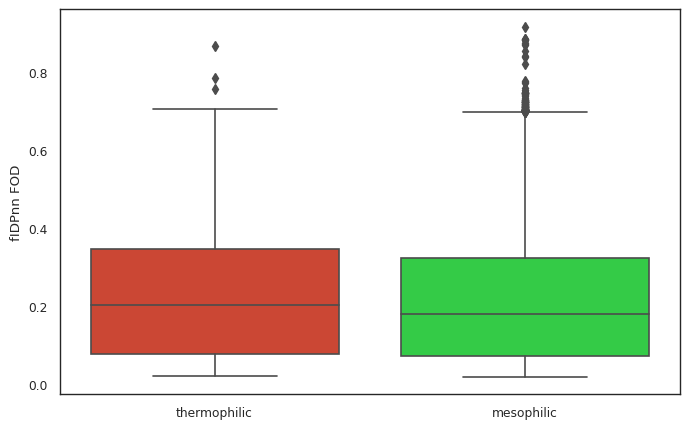

In [74]:
fig, ax = plt.subplots(figsize=(8,5))

sns.boxplot(data=combination_clusters, x='group', y='fIDPnn_FOD', palette=[red, green])
ax.set_xlabel('')
ax.set_ylabel('fIDPnn FOD')

fig.show()

In [75]:
scipy.stats.ttest_ind(combination_clusters[combination_clusters['group']=='mesophilic']['fIDPnn_FOD'],
                      combination_clusters[combination_clusters['group']=='thermophilic']['fIDPnn_FOD'])

TtestResult(statistic=-2.8666677075164304, pvalue=0.004160628358460908, df=6962.0)

In [89]:
combination_clusters.groupby('group')['fIDPnn_FOD'].agg(['mean', 'sem'])

,mean,sem
group,,
mesophilic,0.224642,0.002226
thermophilic,0.247030,0.008055


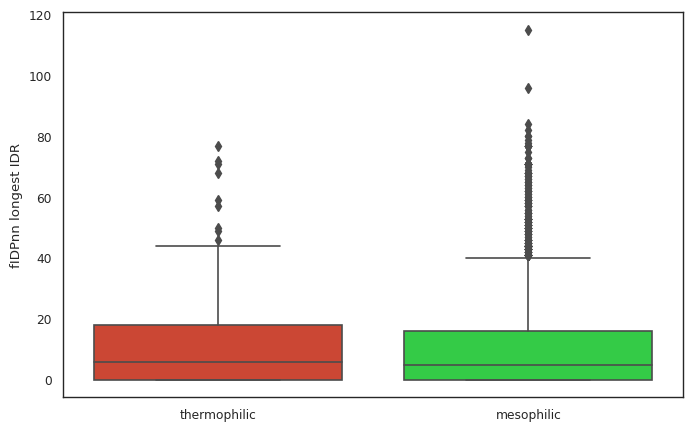

In [82]:
fig, ax = plt.subplots(figsize=(8,5))

sns.boxplot(data=combination_clusters, x='group', y='fIDPnn_longest_IDR', palette=[red, green])
ax.set_xlabel('')
ax.set_ylabel('fIDPnn longest IDR')

fig.show()

In [83]:
scipy.stats.ttest_ind(combination_clusters[combination_clusters['group']=='mesophilic']['fIDPnn_longest_IDR'],
                      combination_clusters[combination_clusters['group']=='thermophilic']['fIDPnn_longest_IDR'])

TtestResult(statistic=-1.543112805050512, pvalue=0.12284885826937211, df=6962.0)

In [88]:
combination_clusters.groupby('group')['fIDPnn_longest_IDR'].agg(['mean', 'sem'])

,mean,sem
group,,
mesophilic,10.084194,0.166940
thermophilic,10.980836,0.552124


In [81]:
disordered_combos = combination_clusters.groupby(['cluster', 'group'], as_index=False)[['fIDPnn_FOD', 'fIDPnn_longest_IDR']].mean()
disordered_combos_std = disordered_combos.groupby('cluster', as_index=False).std()
disordered_combos_std.sort_values('fIDPnn_FOD', ascending=False).head()

,cluster,fIDPnn_FOD,fIDPnn_longest_IDR
86,162959.0,0.215175,9.029210
254,893670.0,0.100280,17.745371
263,908872.0,0.098435,14.418244
184,795294.0,0.083705,1.811961
247,881579.0,0.079525,5.142595


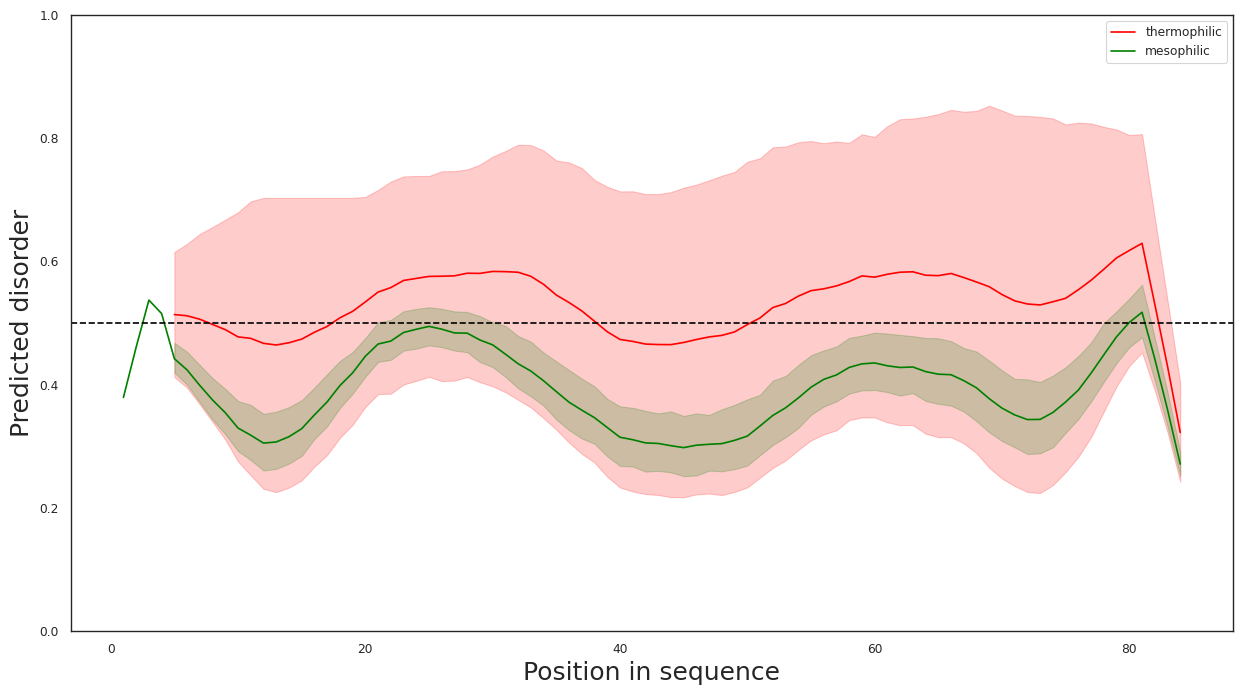

In [93]:
test_cluster = 893670
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

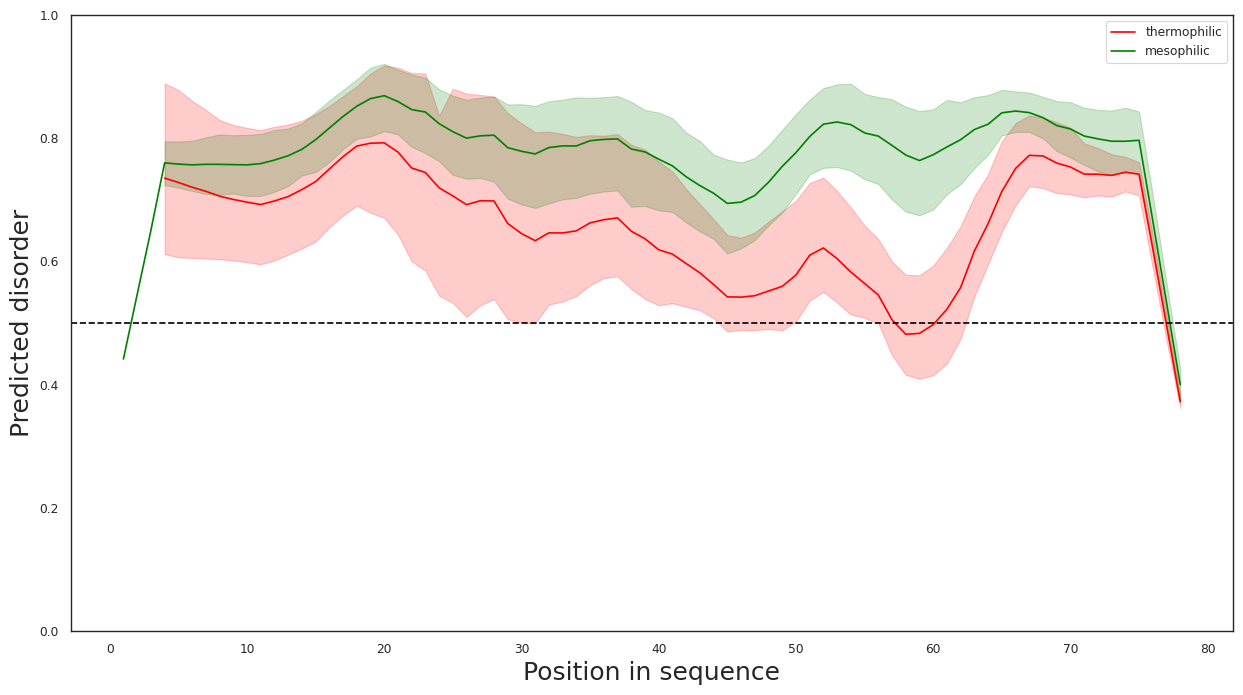

In [92]:
test_cluster = 908872
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

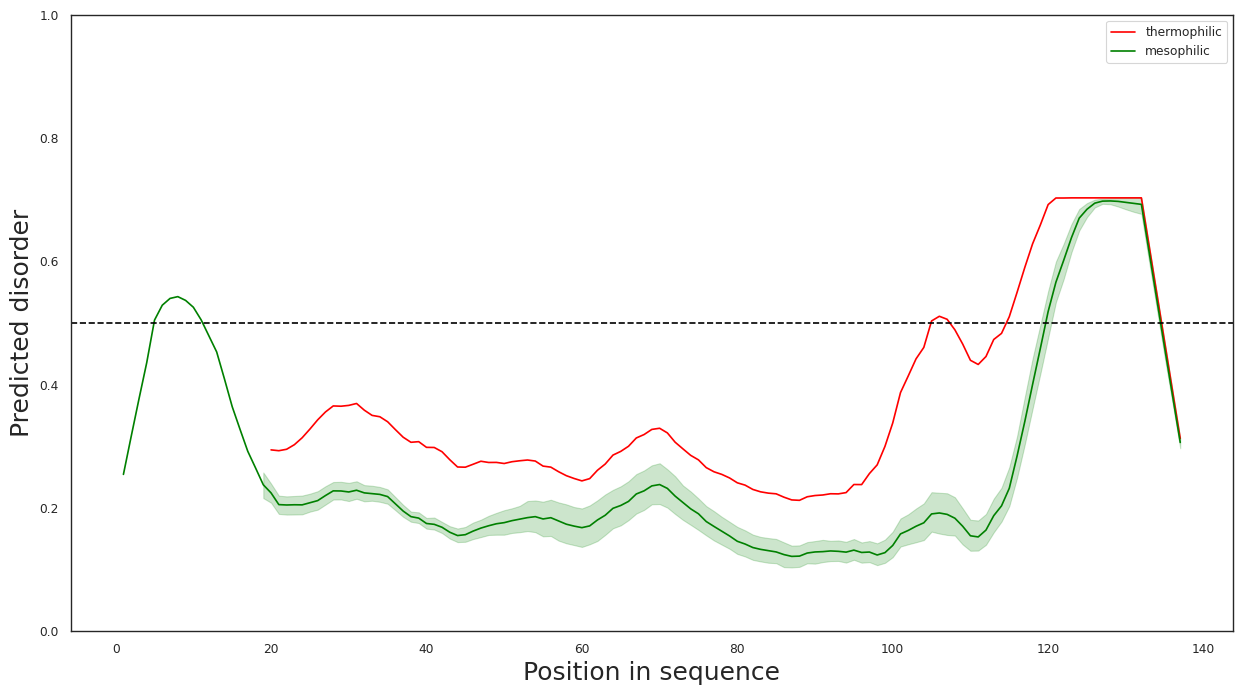

In [94]:
test_cluster = 795294
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

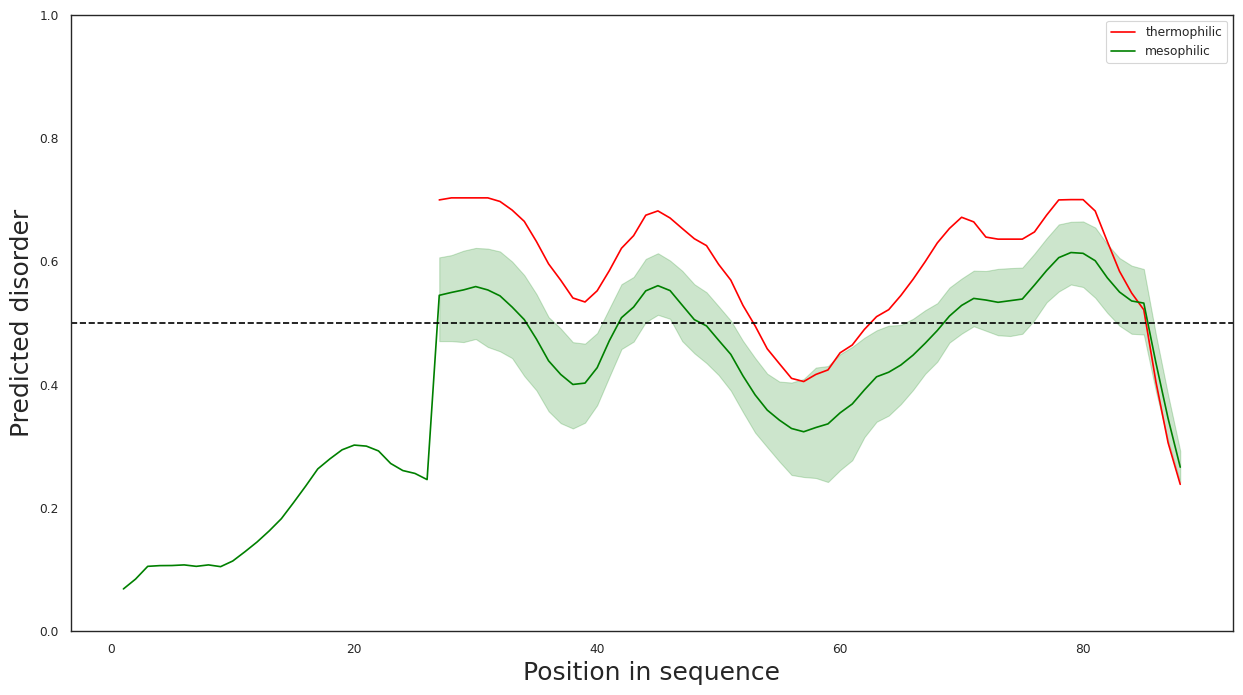

In [95]:
test_cluster = 881579
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

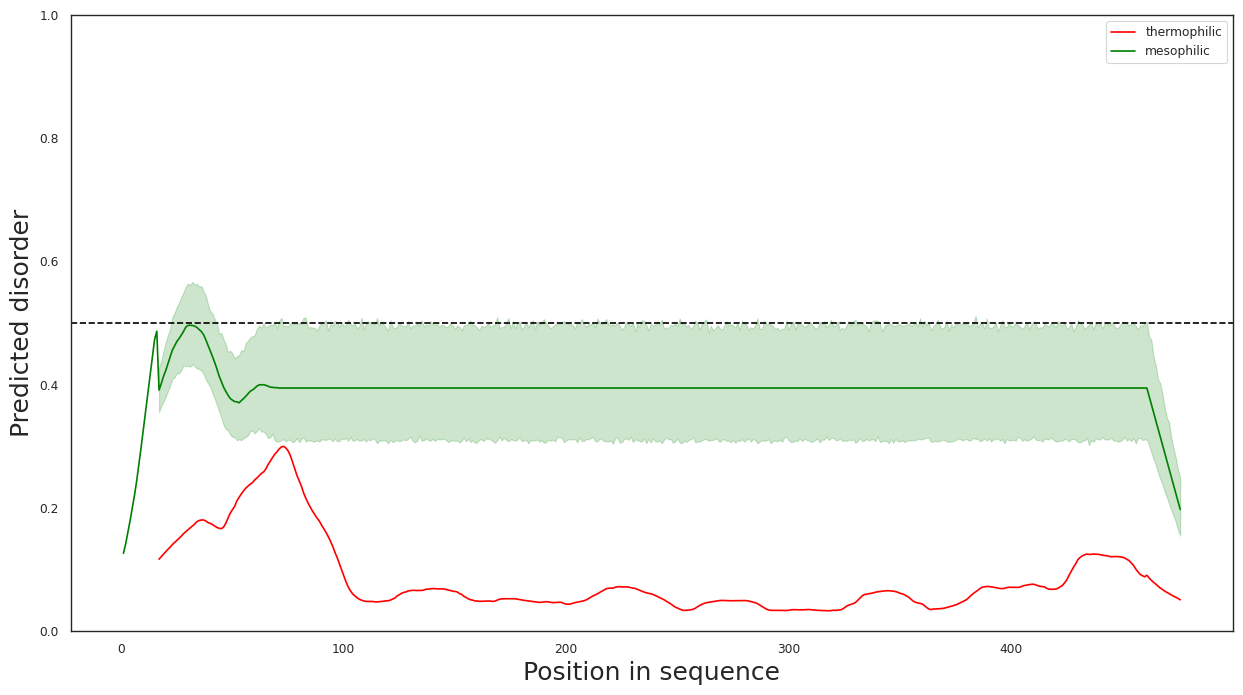

In [96]:
test_cluster = 162959
df = combination_clusters[combination_clusters['cluster']==test_cluster]

plot_aligned_cluster(df=df, cluster=test_cluster, mav=30)

In [ ]:
m_only_clusters = pd.concat(m_only_clusters, ignore_index=True)

In [ ]:
m_only_clusters['cluster'].unique()

array([867336, 823162, 102070, 554059,  28438, 863228, 598028, 897885,
       763199, 924139,   6326, 825598, 871115, 882210, 607453, 902819,
       818343, 798737,   9829, 894420, 192068, 784912,  49148,  42509,
        21139,  83933, 102673, 106885,  67247,  77121,  60800, 159378,
       123788, 771424,  99914, 878189, 870900, 283882, 452861, 855673,
       627800,  56969, 848681, 823297,  31374, 765797, 833070, 108551,
        39665, 742554, 530864, 139250, 365108, 633418, 394369, 512330,
       686643, 130292, 876308, 856550, 485786,  20156, 522451, 460314,
       729232,  29251, 907459,  55166,  85630, 791859, 888681, 744397,
       805314,  15745, 738306, 878211, 847161, 466658, 748221,  69183,
       817242, 824299,  16529, 834464, 394262, 871053, 723937,  30043,
       661130, 723315, 776166, 747759, 305421, 876479, 893868, 101238,
       347823, 891139,  20449, 102765,  44942, 924903, 717273, 777245,
       833641, 574694, 868771, 195354, 412803, 626335, 866619, 688797,
      

In [ ]:
clusters_df = pd.concat(aligned_clusters, ignore_index=True)

In [ ]:
def model_cluster(cluster_number, df=clusters_df, plot=False):
  df = df[df['cluster']==cluster_number]
  df = pd.merge(left=df, right=tempura, left_on='Species', right_on='genus_and_species')
  cluster_model = sm.OLS(df['fIDPnn_FOD'], sm.add_constant(df['Topt_ave'])).fit()

  if plot:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.scatterplot(data=df, x='Topt_ave', y='fIDPnn_FOD', color='black', alpha=0.5, ax=ax)
    sns.lineplot(x=df['Topt_ave'], y=cluster_model.predict(sm.add_constant(df['Topt_ave'])), ax=ax, color='red')
    plt.show()
  return (cluster_model.rsquared, cluster_model.params[1])

In [ ]:
model_results = {cluster:model_cluster(cluster) for cluster in combination_clusters['cluster'].unique()}
model_results = pd.DataFrame(model_results.values(), columns=['rsq', 'coef'], index=model_results.keys())
model_results.sort_values('rsq')

,rsq,coef
878091,0.000003,-0.000028
936233,0.000015,-0.000084
671888,0.000015,-0.000016
201174,0.000019,0.000007
18751,0.000021,-0.000007
...,...,...
787869,0.626497,-0.007024
935329,0.641040,0.001189
595740,0.666311,0.001110
30963,0.670424,-0.000801


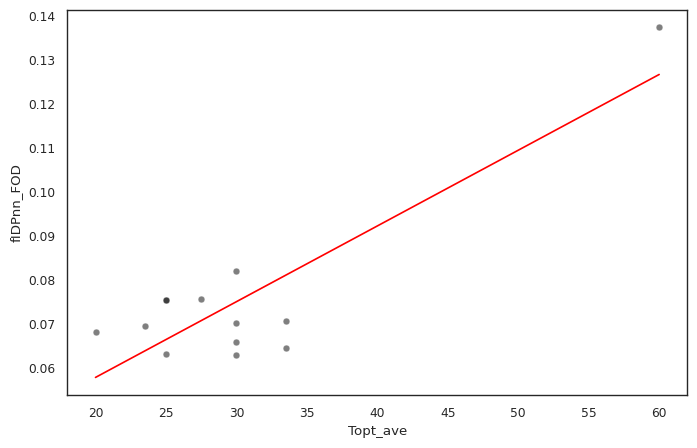

(0.7484539103621783, 0.0017179652677103382)

In [ ]:
model_cluster(73523, plot=True)

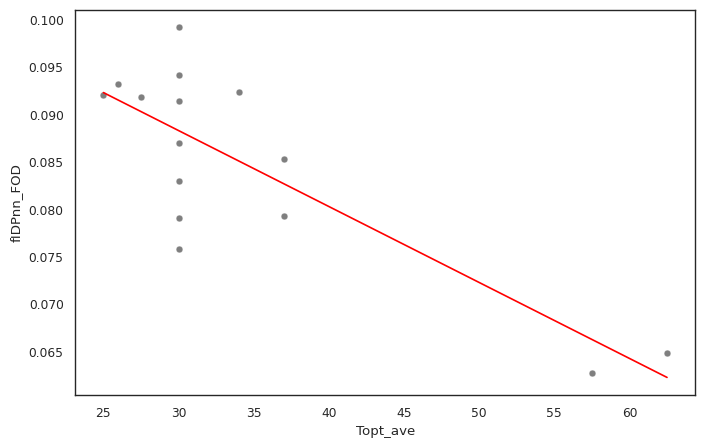

(0.670423727559553, -0.0008005443808093468)

In [ ]:
model_cluster(30963, plot=True)

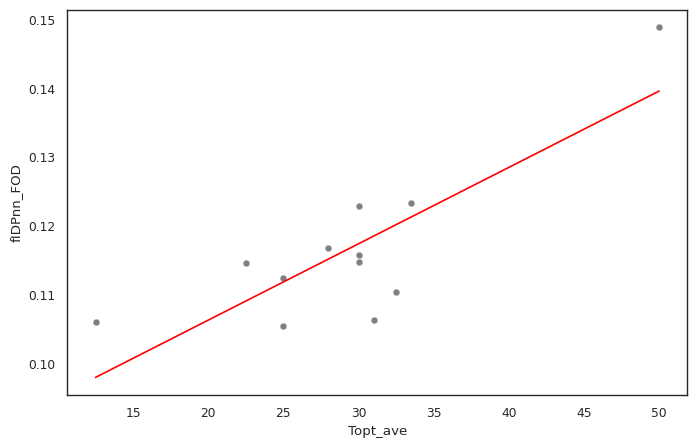

(0.6663107903614167, 0.0011098020402574844)

In [ ]:
model_cluster(595740, plot=True)

In [ ]:
model_results['rsq'].mean()

0.09637009672008726

In [ ]:
model_results['coef'].mean()

0.000565505043197505

In [ ]:
clusters_df = pd.merge(left=clusters_df, right=tempura, left_on='Species', right_on='genus_and_species')

In [ ]:
clusters_df['fIDPnn_FOD']

0        0.050233
1        0.451963
2        0.698795
3        0.361302
4        0.703000
           ...   
13023    0.316621
13024    0.464309
13025    0.252258
13026    0.703490
13027    0.693526
Name: fIDPnn_FOD, Length: 13028, dtype: float64

In [ ]:
X = clusters_df['Topt_ave']
y = clusters_df['fIDPnn_FOD']

FOD_OGT_line_model_clusters = sm.OLS(y, sm.add_constant(X)).fit()
print(FOD_OGT_line_model_clusters.summary())

                            OLS Regression Results                            
Dep. Variable:             fIDPnn_FOD   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     32.59
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           1.16e-08
Time:                        09:21:48   Log-Likelihood:                 3994.2
No. Observations:               13028   AIC:                            -7984.
Df Residuals:                   13026   BIC:                            -7970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1886      0.006     30.137      0.0

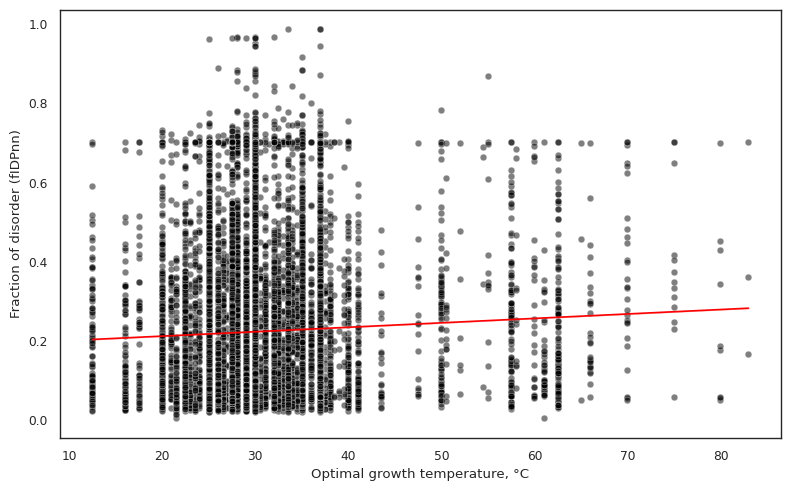

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=clusters_df, x='Topt_ave', y='fIDPnn_FOD', color='black', ax=ax, alpha=0.5)
plt.ylabel('Fraction of disorder (fIDPnn)')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=clusters_df['Topt_ave'], y=FOD_OGT_line_model_clusters.predict(sm.add_constant(clusters_df['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=clusters_df['Topt_ave'], y=FOD_OGT_line_model_clusters.predict(sm.add_constant(clusters_df['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
fig.savefig('FOD_OGT_clusters.svg')

In [ ]:
clusters_df

,ID,Sequence,Length,Species,RAPID_disorder,f_plus,f_minus,ncpr,fcr,idp_type,...,cluster,fIDPnn_disorder,fIDPnn_FOD,fIDPnn_binary,fIDPnn_longest_IDR,fIDPnn_with_IDR,disorder_aligned,group,color,species_tag
0,A0A172T0T8,MAKEKFVRTKPHMNVGTIGHIDHGKTTLTAAITKYCSFFGWAEYTP...,399,Fervidobacterium pennivorans,0.0677,0.145363,0.155388,0.010025,0.300752,2,...,239905,0 0.346 1 0.418 2 0.467 3 ...,0.050233,"[False, False, False, False, False, False, Fal...",0,False,"[nan, 0.346, 0.418, 0.467, 0.423, 0.252, 0.156...",thermophilic,red,Fervidobacterium pennivorans
1,A0A3T0D792,MAKAKFERTKPHVNIGTIGHVDHGKTTLTAAITKVLALKGKAQFMA...,400,Caldicellulosiruptor changbaiensis,0.0725,0.137500,0.142500,0.005000,0.280000,2,...,239905,0 0.403 1 0.475 2 0.496 3 ...,0.055798,"[False, False, False, False, False, False, Fal...",0,False,"[nan, 0.403, 0.475, 0.496, 0.386, 0.231, 0.17,...",thermophilic,red,Caldicellulosiruptor changbaiensis
2,W0DD21,MAKEKFVREKEHVNVGTIGHVDHGKSTLTSAITCVLAAGVLPGGKA...,405,Thermocrinis ruber,0.0691,0.148148,0.158025,0.009877,0.306173,2,...,239905,0 0.215 1 0.332 2 0.414 3 ...,0.054620,"[False, False, False, False, False, False, Fal...",0,False,"[nan, 0.215, 0.332, 0.414, 0.35, 0.255, 0.203,...",thermophilic,red,Thermocrinis ruber
3,A0A101EQ84,MAKEKFVRTKPHVNVGTIGHIDHGKSTLTAAITKYLSLKGLAQYVP...,400,Thermotoga petrophila,0.0800,0.150000,0.157500,0.007500,0.307500,2,...,239905,0 0.307 1 0.381 2 0.433 3 ...,0.057005,"[False, False, False, False, False, False, Fal...",0,False,"[nan, 0.307, 0.381, 0.433, 0.393, 0.215, 0.146...",thermophilic,red,Thermotoga petrophila
4,H7GDF5,MAKGEFXRTKPHXNVGTIGHVDHGKTTLTAALTFVAAAENPNVEVK...,406,Thermus parvatiensis,0.0468,0.145320,0.150246,0.004926,0.295567,2,...,239905,0 0.237 1 0.366 2 0.419 3 ...,0.053271,"[False, False, False, False, False, False, Fal...",0,False,"[nan, 0.237, 0.366, 0.419, 0.307, 0.22, 0.149,...",thermophilic,red,Thermus parvatiensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,A0A2K9PN32,MYLDQKEKESIFKKHGKNAKDTGSAEGQIALFTYRINHLTEHLKNN...,89,Flavivirga eckloniae,0.4382,0.280899,0.123596,0.157303,0.404494,3,...,878751,0 0.410 1 0.462 2 0.498 3 0.45...,0.330348,"[False, False, False, False, False, False, Fal...",4,False,"[0.41, 0.462, 0.498, 0.453, 0.442, 0.454, 0.48...",mesophilic,green,Flavivirga eckloniae
11452,A0A238UDR0,MYLTKEVKEQIFAKHGKDGKDTGTAEGQIALFTHRINHLTEHLKKN...,89,Tenacibaculum jejuense,0.3371,0.303371,0.123596,0.179775,0.426966,3,...,878751,0 0.381 1 0.405 2 0.407 3 0.35...,0.289573,"[False, False, False, False, False, False, Fal...",2,False,"[0.381, 0.405, 0.407, 0.356, 0.339, 0.397, 0.3...",mesophilic,green,Tenacibaculum jejuense
11453,A0A109RPD0,MYLTKEKKAEIFAKHGESATNTGSAEGQIALFTFRINHLTEHLKKN...,89,Lutibacter profundi,0.2360,0.258427,0.112360,0.146067,0.370787,3,...,878751,0 0.382 1 0.412 2 0.427 3 0.38...,0.218843,"[False, False, False, False, False, False, Fal...",2,False,"[0.382, 0.412, 0.427, 0.38, 0.352, 0.39, 0.402...",mesophilic,green,Lutibacter profundi
11454,A0A4P7PRF1,MYLSKDTKAEIFAKHGGKAENTGSAEGQIALFTFRISHLTEHLKKN...,89,Flavobacterium sangjuense,0.2360,0.269663,0.123596,0.146067,0.393258,3,...,878751,0 0.325 1 0.353 2 0.362 3 0.31...,0.195506,"[False, False, False, False, False, False, Fal...",0,False,"[0.325, 0.353, 0.362, 0.318, 0.318, 0.323, 0.3...",mesophilic,green,Flavobacterium sangjuense


In [ ]:
Entrez.email = "akrug104@uottawa.ca"

def get_protein_info(uniprot_id):
  try:
    handle = Entrez.efetch(db="protein", id=uniprot_id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()
    return record[0]['GBSeq_keywords']
  except:
    return None

In [ ]:
get_protein_info('A4G9U0')

['Cytoplasm', 'Elongation factor', 'GTP-binding', 'Nucleotide-binding', 'Protein biosynthesis', 'Reference proteome']

In [ ]:
clusters_df['keywords'] = clusters_df['ID'].apply(get_protein_info)

In [ ]:
clusters_df.loc[205]

ID                                                               A4G9U0
Sequence              MAKGKFERTKPHVNVGTIGHVDHGKTTLTAAIATVLSKKFGGEAKG...
Length                                                              396
Species                                    Herminiimonas arsenicoxydans
RAPID_disorder                                                   0.0354
f_plus                                                         0.138889
f_minus                                                        0.141414
ncpr                                                           0.002525
fcr                                                            0.280303
idp_type                                                              2
disordered                                                        False
cluster                                                          239905
fIDPnn_disorder       0      0.407
1      0.499
2      0.551
3      ...
fIDPnn_FOD                                                     0

## Compare RAPID and fIDPnn

In [ ]:
X = pd.concat([interesting_clusters['RAPID_disorder'], disordered_clusters['RAPID_disorder']], ignore_index=True)
y = pd.concat([interesting_clusters['fIDPnn_FOD'], disordered_clusters['fIDPnn_FOD']], ignore_index=True)

model_comparison_ols = sm.OLS(y, X).fit()

In [ ]:
print(model_comparison_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:             fIDPnn_FOD   R-squared (uncentered):                   0.885
Model:                            OLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                          5.202e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:01:20   Log-Likelihood:                          5301.9
No. Observations:                6786   AIC:                                 -1.060e+04
Df Residuals:                    6785   BIC:                                 -1.060e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

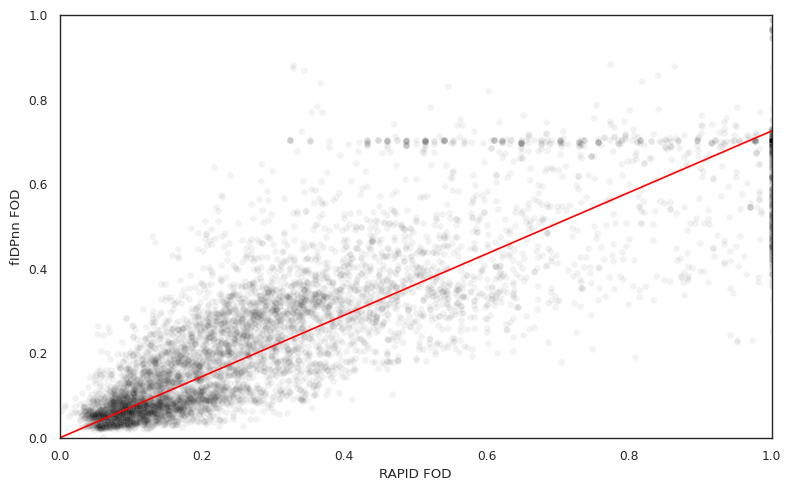

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(x=X, y=y, alpha=0.05, color='black')
ax.plot(model_comparison_ols.predict([0, 1]), color='red')

plt.ylabel('fIDPnn FOD')
plt.xlabel('RAPID FOD')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.tight_layout()
fig.show()
# fig.savefig('RAPID_vs_fIDPnn.svg')

RAPID seems to be an adequate model when compared with fIDPnn, even though it generally does **underpredict** disorder based on coefficient